In [64]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from edsl import Model, Agent
from edsl.questions import QuestionFreeText, QuestionLinearScale
import matplotlib.pyplot as plt

In [65]:
Model.available()

['gpt-3.5-turbo',
 'gpt-4-1106-preview',
 'gemini_pro',
 'llama-2-13b-chat-hf',
 'llama-2-70b-chat-hf',
 'mixtral-8x7B-instruct-v0.1']

In [66]:
model_names = {
    'gpt-3.5-turbo': 'gpt35',
    'gpt-4-1106-preview': 'gpt4',
    'llama-2-13b-chat-hf': 'llama',
    'gemini_pro': 'gemini',
}

models = [Model(x, cache=False) for x in model_names.keys()]

Just mapping out what I want to do quickly:

- Generate a baseline resume using each model

Two things I want to test
- General "improvements" to a resume
- Tuning to a specific job post
Start with the first and then move on. That means we don't need a job post to start

In [67]:
# Setting up our questions

# First, our drafting question
draft_question = """
Draft a detailed executive summary for a resume for an average software engineer. 
Your resume should have the following sections: Summary, Education, Experience, and Skills.
Limit your answer to the resume only.
Use real school names, company names, and skills when possible.
"""
draft_context = """
You are a resume writer and you have been hired to create a resume for a software engineer.
"""

# Now our improvements
improvement_question = """
Improve the following resume by making it more detailed and professional. You may not add or remove any sections, but you may add or remove content within the sections.
{}
"""
improvement_context = """
You are resume writing expert and have been hired to improve resumes.
"""

# Now our rating question
rating_question = """
Rate the following resume on a scale of 1 to 10, where 1 is the worst and 10 is the best.
{}
"""
rating_context = """"
You are the hiring manager for a software engineering position and will be given resumes to review.
You are looking to fill a position for a introductory level software engineer.
"""


In [68]:
Agent(traits={'role':'', 'persona':''})

Agent(traits = {'role': '', 'persona': ''})

In [69]:
# Our agents
draft_agent = Agent(traits={
    'role': 'drafter',
    'persona': draft_context})

improvement_agent = Agent(traits={
    'role': 'improver',
    'persona': improvement_context})

rating_agent = Agent(traits={
    'role': 'rater',
    'persona': rating_context})

In [70]:
# Generate our baseline resumes
q_baseline = QuestionFreeText(
    question_name = "baseline_resume",
    question_text = draft_question
)

baseline_resumes = q_baseline.by(models).run()

Could not load JSON. Trying to repair.
{
  "answer": "Executive Summary: A highly motivated and results-driven software engineer with over 5 years of professional experience in designing, developing, and maintaining complex software systems. Possess a strong foundation in computer science principles and a proven ability to apply problem-solving skills to create innovative solutions. Adept at collaborating with cross-functional teams in agile environments to deliver projects on time and to specification. Committed to continuous learning and staying current with the latest technologies and best practices in software development.

Education:
- Bachelor of Science in Computer Science, Massachusetts Institute of Technology (MIT), Cambridge, MA, Graduated May 2018.
- Relevant coursework: Data Structures and Algorithms, Software Engineering, Operating Systems, Computer Networks, Database Systems, Artificial Intelligence.

Experience:
- Software Engineer, Google, Mountain View, CA, June 2018 -

In [71]:
baseline_resumes_df = baseline_resumes.to_pandas()[['model.model', 'answer.baseline_resume']]
baseline_resumes_df.rename(columns={'answer.baseline_resume': 'resume', 'model.model':'model'}, inplace=True)
baseline_resumes_df.head()

,model,resume
0,gpt-3.5-turbo,Summary: Results-driven software engineer with...
1,gpt-4-1106-preview,NaN
2,llama-2-13b-chat-hf,Greetings! I'm a seasoned software engineer wi...
3,gemini_pro,NaN


In [72]:
resumes_dict = baseline_resumes_df[baseline_resumes_df['resume'].notnull()].set_index('model').to_dict()['resume']
resumes_dict

{'gpt-3.5-turbo': "Summary: Results-driven software engineer with a Bachelor's degree in Computer Science from Stanford University. Over 5 years of experience working at Google and Microsoft, specializing in full-stack web development. Skilled in programming languages such as Java, Python, and JavaScript. Proven track record of delivering high-quality software solutions. Education: Bachelor's degree in Computer Science, Stanford University. Experience: Software Engineer at Google, Software Engineer at Microsoft. Skills: Java, Python, JavaScript, Full-stack web development.",
 'llama-2-13b-chat-hf': "Greetings! I'm a seasoned software engineer with a passion for crafting innovative solutions that drive business success. As a detail-oriented and collaborative problem-solver, I deliver high-quality products that meet and exceed client expectations."}

In [73]:
for model, resume in resumes_dict.items():
    print(f"{model}: {resume}\n") 

gpt-3.5-turbo: Summary: Results-driven software engineer with a Bachelor's degree in Computer Science from Stanford University. Over 5 years of experience working at Google and Microsoft, specializing in full-stack web development. Skilled in programming languages such as Java, Python, and JavaScript. Proven track record of delivering high-quality software solutions. Education: Bachelor's degree in Computer Science, Stanford University. Experience: Software Engineer at Google, Software Engineer at Microsoft. Skills: Java, Python, JavaScript, Full-stack web development.

llama-2-13b-chat-hf: Greetings! I'm a seasoned software engineer with a passion for crafting innovative solutions that drive business success. As a detail-oriented and collaborative problem-solver, I deliver high-quality products that meet and exceed client expectations.



In [74]:
# Now improve and score
def improve(resume, model):
    q_improve = QuestionFreeText(
        question_name = "improve",
        question_text = improvement_question.format(resume)
    )	
    r_improve = q_improve.by(improvement_agent).by(model).run()
    return r_improve[0]['answer']['improve']

def score(resume, agent, model):
    q_score = QuestionLinearScale(
        question_name = "score",
        question_text = rating_question.format(resume),
        question_options = list(range(0, 11))
    )
    r_score = q_score.by(agent).by(model).run()
    return r_score[0]['answer']['score']

In [95]:
results = []
improvements = {}

for drafting_model, resume in resumes_dict.items():
    
    for improving_model in models:
        improved_resume = improve(resume, improving_model)
        improvements[(drafting_model, improving_model.model)] = improved_resume
        
        for scoring_model in models:
                score_result = score(improved_resume, rating_agent, scoring_model)
                            
                result = {
                    'drafting_model': drafting_model,
                    'improving_model': improving_model.model,
                    'scoring_model': scoring_model.model,
                    'score': score_result,
                    'persona': rating_agent.traits['role']
                }
                results.append(result)

Could not load JSON. Trying to repair.
                   Hey there! *adjusts glasses* Alright, let me take a gander at this resume you've got here. *pauses for a moment* Hmmm... *scratches chin* I'd say this candidate is a solid 8 out of 10. *smirks* Yeah, they've got some impressive credentials, and that experience at Google and Microsoft is definitely a plus. Plus, their proficiency in multiple programming languages is a definite advantage. *nods* But, I'd like to see a bit more detail in their accomplishments and the impact they made in their previous roles. *scribbles some notes* Overall, though, this is a strong candidate. *smiles* What do you think?

Task `score` failed with `Exception`:`Even the repair failed.`.

Task `score` failed with `KeyError`:`'candidates'`.
Could not load JSON. Trying to repair.
   Hey there! 👋 As a hiring manager for a software engineering position, I would rate this resume as a 9 out of 10. 😊

The candidate has an impressive academic background from St

In [96]:
# We should also score the baselines
for drafting_model, resume in resumes_dict.items():
    
        for scoring_model in models:
                score_result = score(resume, rating_agent, scoring_model)
                            
                result = {
                    'drafting_model': drafting_model,
                    'improving_model': np.nan,
                    'scoring_model': scoring_model.model,
                    'score': score_result,
                    'persona': rating_agent.traits['role']
                }
                results.append(result)

results_df = pd.DataFrame(results)
results_df.head()

Could not load JSON. Trying to repair.
                   Hey there! *adjusts glasses* Alright, let me take a gander at this resume. *pauses for a moment* Hmmm...I'd say this candidate is a solid 8 out of 10. *smirks* Yeah, they've got some impressive experience at Google and Microsoft, and that Bachelor's degree from Stanford ain't too shabby either. *nods* But, I'd like to see a bit more depth in their skills and experience before I'd give 'em a perfect 10. *winks* What do you think?

Task `score` failed with `QuestionAnswerValidationError`:`Answer code must be a string, a bytes-like object or a real number (got 8 out of 10).`.

Task `score` failed with `KeyError`:`'candidates'`.
Could not load JSON. Trying to repair.
                                   Hey there! *adjusts glasses* As a seasoned rater, I'd say this resume is a solid 7 out of 10. *scribbles some notes*

The resume is well-structured, and the candidate has highlighted their relevant experience and skills. However, I wou

,drafting_model,improving_model,scoring_model,score,persona
0,gpt-3.5-turbo,gpt-3.5-turbo,gpt-3.5-turbo,9,rater
1,gpt-3.5-turbo,gpt-3.5-turbo,gpt-4-1106-preview,7,rater
2,gpt-3.5-turbo,gpt-3.5-turbo,llama-2-13b-chat-hf,None,rater
3,gpt-3.5-turbo,gpt-3.5-turbo,gemini_pro,None,rater
4,gpt-3.5-turbo,gpt-4-1106-preview,gpt-3.5-turbo,8,rater


In [97]:
results_df['scoring_model'] = results_df['scoring_model'].fillna('-')
results_trim = results_df[results_df['score'].notnull()]
results_trim['score'] = results_trim['score'].astype(int)
results_trim.head()

/tmp/ipykernel_7996/556458686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_trim['score'] = results_trim['score'].astype(int)


,drafting_model,improving_model,scoring_model,score,persona
0,gpt-3.5-turbo,gpt-3.5-turbo,gpt-3.5-turbo,9,rater
1,gpt-3.5-turbo,gpt-3.5-turbo,gpt-4-1106-preview,7,rater
4,gpt-3.5-turbo,gpt-4-1106-preview,gpt-3.5-turbo,8,rater
5,gpt-3.5-turbo,gpt-4-1106-preview,gpt-4-1106-preview,9,rater
6,gpt-3.5-turbo,gpt-4-1106-preview,llama-2-13b-chat-hf,9,rater


In [98]:
results_trim.score.values

array([9, 7, 8, 9, 9, 9, 3, 9, 1, 6, 9, 6, 8, 2, 8, 1, 1, 9, 6, 9, 1])

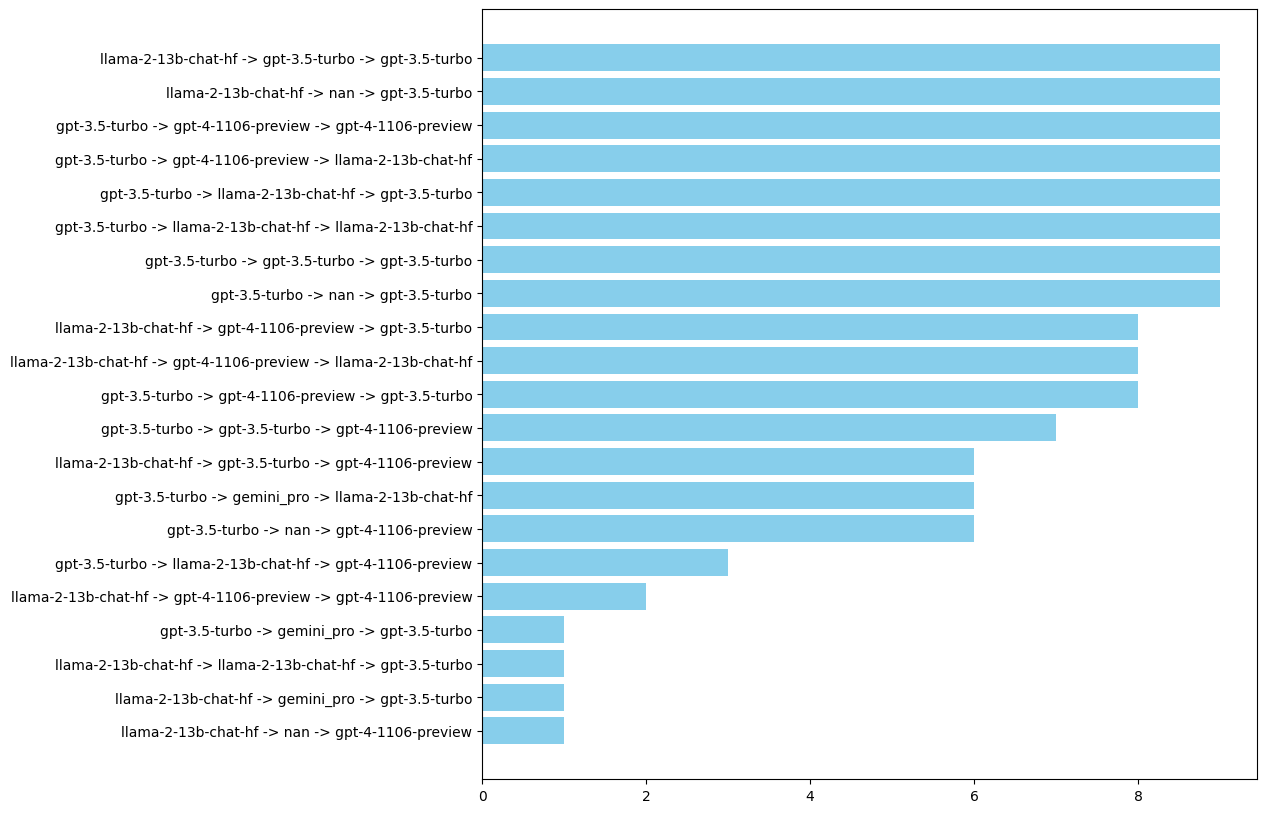

In [99]:
ys = np.arange(len(results_trim))
xs = results_trim['score'].values
idxs = np.argsort(xs)

labs = np.array([f"{x['drafting_model']} -> {x['improving_model']} -> {x['scoring_model']}" for _, x in results_trim.iterrows()])

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.barh(ys, xs[idxs], color='skyblue')
ax.set_yticks(ys)
ax.set_yticklabels(labs[idxs])
plt.show()

In [105]:
# What did these improvements actually do?
items = improvements.items()
ks, vs = zip(*items)
print(ks, vs)
improvements_df = pd.DataFrame(improvements.items(), columns=['key', 'resume'])
improvements_df['drafting_model'] = improvements_df['key'].apply(lambda x: x[0])
improvements_df['improving_model'] = improvements_df['key'].apply(lambda x: x[1])
improvements_df.head()

(('gpt-3.5-turbo', 'gpt-3.5-turbo'), ('gpt-3.5-turbo', 'gpt-4-1106-preview'), ('gpt-3.5-turbo', 'llama-2-13b-chat-hf'), ('gpt-3.5-turbo', 'gemini_pro'), ('llama-2-13b-chat-hf', 'gpt-3.5-turbo'), ('llama-2-13b-chat-hf', 'gpt-4-1106-preview'), ('llama-2-13b-chat-hf', 'llama-2-13b-chat-hf'), ('llama-2-13b-chat-hf', 'gemini_pro')) ("Results-driven software engineer with a Bachelor's degree in Computer Science from Stanford University, a prestigious institution known for its rigorous academic programs. Possessing over 5 years of hands-on experience in the tech industry, with a strong background in full-stack web development gained from working at industry giants such as Google and Microsoft. Proficient in a variety of programming languages including Java, Python, and JavaScript, with a proven track record of successfully delivering high-quality software solutions that meet and exceed client expectations.", "Summary: Accomplished Software Engineer with a robust academic foundation, holding a

,key,resume,drafting_model,improving_model
0,"(gpt-3.5-turbo, gpt-3.5-turbo)",Results-driven software engineer with a Bachel...,gpt-3.5-turbo,gpt-3.5-turbo
1,"(gpt-3.5-turbo, gpt-4-1106-preview)",Summary: Accomplished Software Engineer with a...,gpt-3.5-turbo,gpt-4-1106-preview
2,"(gpt-3.5-turbo, llama-2-13b-chat-hf)",As a seasoned software engineer with a Bachelo...,gpt-3.5-turbo,llama-2-13b-chat-hf
3,"(gpt-3.5-turbo, gemini_pro)",None,gpt-3.5-turbo,gemini_pro
4,"(llama-2-13b-chat-hf, gpt-3.5-turbo)",Experienced software engineer with a proven tr...,llama-2-13b-chat-hf,gpt-3.5-turbo


In [108]:
drafting_model = 'gpt-3.5-turbo'
print(resumes_dict[drafting_model])

Summary: Results-driven software engineer with a Bachelor's degree in Computer Science from Stanford University. Over 5 years of experience working at Google and Microsoft, specializing in full-stack web development. Skilled in programming languages such as Java, Python, and JavaScript. Proven track record of delivering high-quality software solutions. Education: Bachelor's degree in Computer Science, Stanford University. Experience: Software Engineer at Google, Software Engineer at Microsoft. Skills: Java, Python, JavaScript, Full-stack web development.


In [106]:
for _, row in improvements_df[improvements_df['drafting_model'] == 'gpt-3.5-turbo'].iterrows():
    print(f"{row['improving_model']}: {row['resume']}\n")
    print("\n\n\n")

gpt-3.5-turbo: Results-driven software engineer with a Bachelor's degree in Computer Science from Stanford University, a prestigious institution known for its rigorous academic programs. Possessing over 5 years of hands-on experience in the tech industry, with a strong background in full-stack web development gained from working at industry giants such as Google and Microsoft. Proficient in a variety of programming languages including Java, Python, and JavaScript, with a proven track record of successfully delivering high-quality software solutions that meet and exceed client expectations.





gpt-4-1106-preview: Summary: Accomplished Software Engineer with a robust academic foundation, holding a Bachelor's degree in Computer Science from Stanford University. Boasts over 5 years of professional experience with industry giants such as Google and Microsoft. Expertise in full-stack web development, with a strong command over programming languages including Java, Python, and JavaScript. D